<a href="https://colab.research.google.com/github/gizattos/Diabetes-Classificar/blob/master/Classifica%C3%A7%C3%A3o%20de%20pacientes%20com%20diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utilizando o dataset "Pima Indians Diabetes Database" crie um modelo para diagnosticar um paciente como diabético ou não. Discuta sobre a tarefa, o dataset, valores nulos, feature engineering, escolha do modelo, avaliação do modelo, importância das featires, métricas escolhidas (e porquê) e matriz de confusão.

In [0]:
## bibliotecas 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

<h1>Variáveis</h1>
<h2>
Pregnancies: número de vezes grávida <br>
Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test<br>
BloodPressure: Diastolic blood pressure (mm Hg)<br>
SkinThickness: Triceps skin fold thickness (mm)<br>
Insulin: 2-Hour serum insulin (mu U/ml)<br>
BMI: Body mass index (weight in kg/(height in m)^2) <br>
DiabetesPedigreeFunction:Diabetes pedigree function<br>
Age:Age (years) <br>
Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0





 </h2>


<h2> Lendo CSV </h2>



In [0]:
df = pd.read_csv('/content/diabetes.csv')

In [47]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<h2>Explorando dataset</h2>

In [48]:
## dados faltantes
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [49]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<h3>De acordo com o artigo https://www.sciencedirect.com/science/article/pii/S2352914816300016 , em alguns casos o valor 0 foi posto no lugar de valores faltantes, não possibilitando saber quando é um missing ou quando é um valor real </h3>

In [50]:
## quantidade de zeros por coluna
(df == 0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [0]:
## trocando valores das colunas Glucose, BloodPressure , SkinThickness , Insulin , BMI pela mediana
median_Glucose = df['Glucose'].median(skipna=True)
median_BloodPressure = df['BloodPressure'].median(skipna=True)
median_SkinThickness = df['SkinThickness'].median(skipna=True)
median_Insulin = df['Insulin'].median(skipna=True)
median_BMI = df['BMI'].median(skipna=True)
df=df.replace({'Glucose': {0: median_Glucose}})
df=df.replace({'BloodPressure': {0: median_BloodPressure}}) 
df=df.replace({'SkinThickness': {0: median_SkinThickness}}) 
df=df.replace({'Insulin': {0: median_Insulin}}) 
df=df.replace({'BMI': {0: median_BMI}})  


In [52]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [53]:
## correlação entre variáveis para visualizar se existe alguma variável explicativa com correlação muito alta com outra
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128213,0.208615,0.032568,-0.055697,0.021546,-0.033523,0.544341,0.221898
Glucose,0.128213,1.000000,0.218937,0.172143,0.357573,0.231400,0.137327,0.266909,0.492782
BloodPressure,0.208615,0.218937,1.000000,0.147809,-0.028721,0.281132,-0.002378,0.324915,0.165723
SkinThickness,0.032568,0.172143,0.147809,1.000000,0.238188,0.546951,0.142977,0.054514,0.189065
Insulin,-0.055697,0.357573,-0.028721,0.238188,1.000000,0.189022,0.178029,-0.015413,0.148457
BMI,0.021546,0.231400,0.281132,0.546951,0.189022,1.000000,0.153506,0.025744,0.312249
DiabetesPedigreeFunction,-0.033523,0.137327,-0.002378,0.142977,0.178029,0.153506,1.000000,0.033561,0.173844
Age,0.544341,0.266909,0.324915,0.054514,-0.015413,0.025744,0.033561,1.000000,0.238356
Outcome,0.221898,0.492782,0.165723,0.189065,0.148457,0.312249,0.173844,0.238356,1.000000


In [0]:
## definindo X e Y
x = df.drop(['Outcome'],axis=1) 
y = df['Outcome']

<h2>Descision Tree</h2>

In [55]:
## Separando em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
dt = tree.DecisionTreeClassifier(criterion='entropy')
dt.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
## predizendo x_test
y_pred = dt.predict(x_test)

In [57]:
## importancia de cada variável
print(dt.feature_importances_)
print(x.columns)

[0.09472059 0.27871494 0.11764437 0.06033493 0.06081303 0.14371617
 0.07754142 0.16651454]
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


<h2>Podemos visualizar que de todas as variáveis, Glucose e BMI são as mais importantes pro modelo</h2>

In [58]:
## matrix de confusão com precisão, recall, f1-scope e support
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[77 22]
 [19 36]]
              precision    recall  f1-score   support

           0       0.80      0.78      0.79        99
           1       0.62      0.65      0.64        55

    accuracy                           0.73       154
   macro avg       0.71      0.72      0.71       154
weighted avg       0.74      0.73      0.74       154



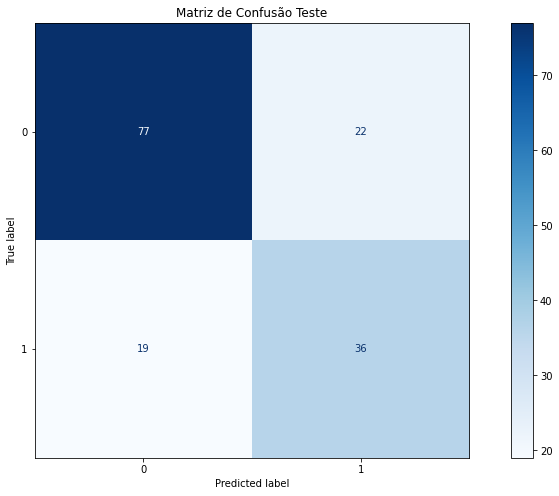

In [67]:
## plotando Matriz de confusão do teste
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(dt,x_test,y_test,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Teste')

plt.show()

<h2>O modelo obteve 73% de acerto, obtendo melhores resultados prevendo resultados 0, onde classificou 77 pessoas corretamente e 22 de forma incorreta. Já para paciente que possuem diabetes o modelo tem um erro maior, classificando corretamente 36 e de forma incorreta 19. Por se tratar de saúde, um acerto menos na calssificação da diabetes é um problema, pois assim aproximadamente 35% das pessoas que possuem diabetes, seriam mandadas para casa com um prognóstico incorreto.</h2>

In [60]:
## matrix de confusão com precisão, recall, f1-scope e support
y_pred_train = dt.predict(x_train)
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[401   0]
 [  0 213]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



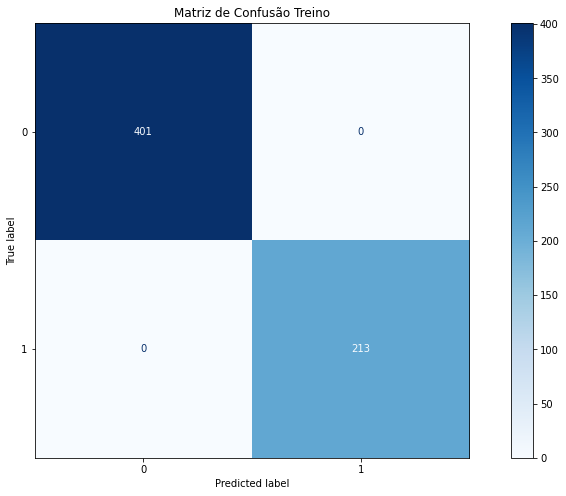

In [68]:
## plotando Matriz de confusão do treino
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(dt,x_train,y_train,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Treino')

plt.show()

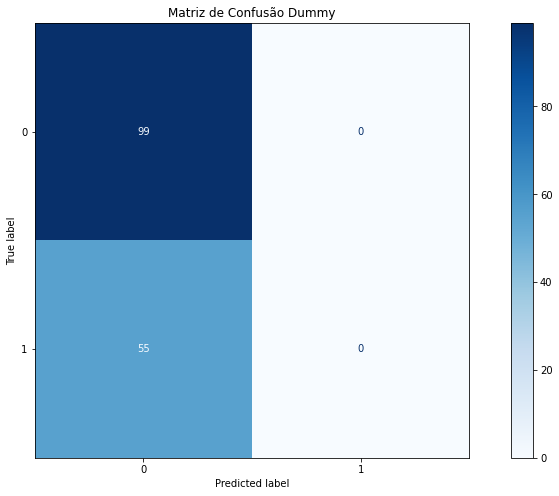

In [69]:
## plotando Matriz de confusão Dummy
f, ax = plt.subplots(1,1,figsize=(15,8))

plot_confusion_matrix(DummyClassifier(strategy='most_frequent').fit(x_train,y_train),x_test,y_test,ax=ax,cmap=plt.cm.Blues,values_format='.4g')

ax.set_title('Matriz de Confusão Dummy')

plt.show()

<h3>O modelo de treino acertou 100%, enquanto o modelo de teste teve uma acurácia de 73%, isso é característica de um modelo com overfit, que acabou decorando os dados do treino, possuindo resultados bem diferentes entre treino e teste.<br>Para efeito de comparação também foi plotado uma matriz de confusão utilizando o modelo dummy, esse chegou a 63% de acurácia, mostrando que mesmo o modelo estando overfitado, ainda sim é melhor que o modelo dummy.</h3>

In [63]:
## predizendo resultado 
dt.predict([[2,3,4,4,5,3,4,30]])

array([0])

In [64]:
## mostrando probabilidade do resultado
dt.predict_proba([[2,3,4,4,5,3,4,30]])

array([[1., 0.]])